# Section 2: Unncovering brain-behavior relationships and overcoming overfitting with regularization

In this section, we're going to use tools learnt in Section 1 and learn about methods to uncover relationships between hypothalamic neural activity and social behavior using a dataset from [Remedios et ., 2017, Nature](https://https://www.nature.com/articles/nature23885)

In [365]:
# Import neccessary modules and helper functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.decomposition import PCA

# Set color map for indicating behaviors
color_names = ["grey",
               "red",
               "forest green",
               "amber",
               "windows blue"]
colors = sns.xkcd_palette(color_names)
colors_sex = sns.xkcd_palette(color_names[2:5])
colors_beh = sns.xkcd_palette(color_names)

cmap_beh = ListedColormap(colors)
cmap_sex = ListedColormap(colors[2:4])

def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    
def plot_trajectory_beh(z, x,a1,a2,ax=None, alpha = 1, ls="-", colors = colors):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, a1],
                x[start:stop + 1, a2],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=alpha)
    return ax

*Include explanation about dataset here with figure*

In [225]:
# Load data

remedios_data = loadmat("VMHvl_Remedios.mat");

neural_data = remedios_data['neural_data']
attack_vector = remedios_data['attack_vector']
sex_vector = remedios_data['sex_vector']


Let's visualize the neural data and plot an activity matrix, a plot showing the behaviors perfomed by the resident mouse and some example neurons

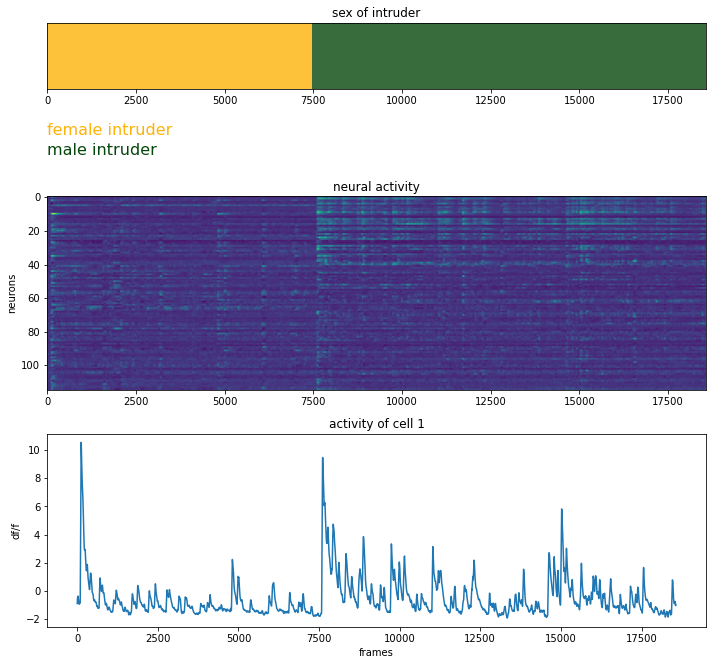

In [412]:
# Create a plot for showing behavior raster, neural raster & an example neuron

plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
ax1.imshow(sex_vector, aspect='auto', cmap=cmap_sex, alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('sex of intruder')
ax1.text(0,1.2,'female intruder ',color = colors_sex[1],fontsize=16)
ax1.text(0,1.5,'male intruder',color = colors_sex[0],fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(neural_data, aspect='auto')
ax2.set_title('neural activity')
ax2.set_ylabel('neurons')

ax3 = plt.subplot(313)
ax3.plot(neural_data[0,])
ax3.set_title('activity of cell 1')
ax3.set_ylabel('df/f')
ax3.set_xlabel('frames')

plt.tight_layout() 


Let's now use what we learnt in Section 1 to perform PCA on this data and examine the top 2 principal components

Text(0.02, 0.017, 'male intruder')

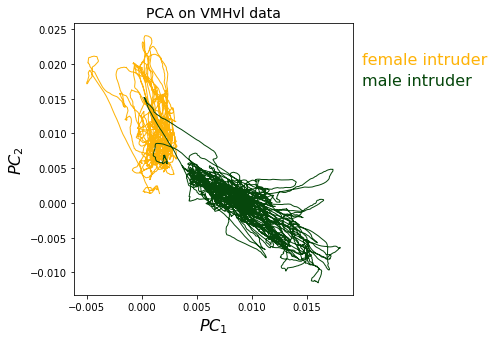

In [247]:
# perform PCA
pca_neural = PCA(n_components=2)
pca_neural.fit_transform (neural_data)
neural_pcs = pca_neural.components_

# plot PCA, colored by intruder sex
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
plot_trajectory_beh(sex_vector[0,:],neural_pcs.T,0,1,ax=ax, colors = colors_sex)
ax.set_title('PCA on VMHvl data',fontsize = 14)
ax.set_xlabel('$PC_1$',fontsize=16)
ax.set_ylabel('$PC_2$',fontsize=16)
ax.text(0.02,0.02,'female intruder ',color = colors_sex[1],fontsize=16)
ax.text(0.02,0.017,'male intruder',color = colors_sex[0],fontsize=16)


This produces a key result in Remedios et al., where the primary source of variance in VMHvl is the sex of the intruder and thus male and female interactions are seperable in PCA space.

Let's now consider correlating neural activity with a behavior such as attack, which is causally linked to VMHvl

Text(0.02, 0.02, 'attack')

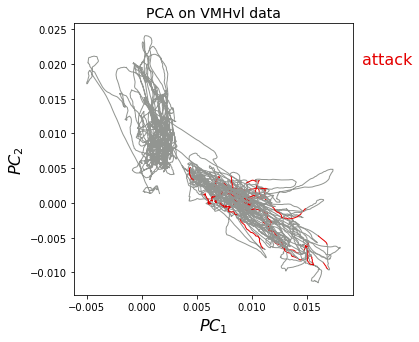

In [297]:
# plot PCA, colored by attack
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
plot_trajectory_beh(attack_vector[0,:],neural_pcs.T,0,1,ax=ax)
ax.set_title('PCA on VMHvl data',fontsize = 14)
ax.set_xlabel('$PC_1$',fontsize=16)
ax.set_ylabel('$PC_2$',fontsize=16)
ax.text(0.02,0.02,'attack',color = colors_beh[1],fontsize=16)

Text(0, 0.5, 'neurons')

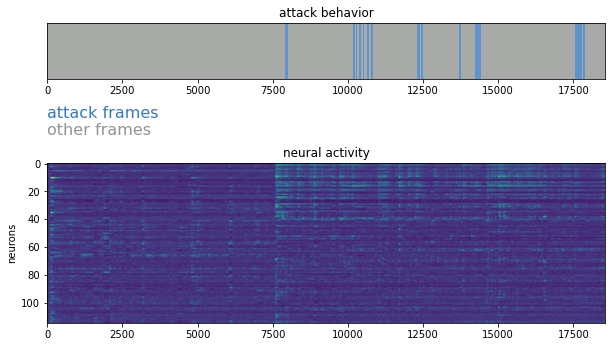

In [413]:
# plot neural activity, showing frames of attack

plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
ax1.imshow(attack_vector, aspect='auto', cmap=cmap_beh, alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior')
ax1.text(0,1.2,'attack frames',color = colors_beh[4],fontsize=16)
ax1.text(0,1.5,'other frames',color = colors_beh[0],fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(neural_data, aspect='auto')
ax2.set_title('neural activity')
ax2.set_ylabel('neurons')

Despite this causal link, the seperation between frames of attack vs other behaviors is not very apparent, let's train a simple linear regression model to estimate if attack can be decoded from this population.

The first step involves splitting data into train & test splits. As a first pass, let's split the last third of the data into the test set

We then use sklearn's LinearRegression module to perform the actual regression and report performance as an R2

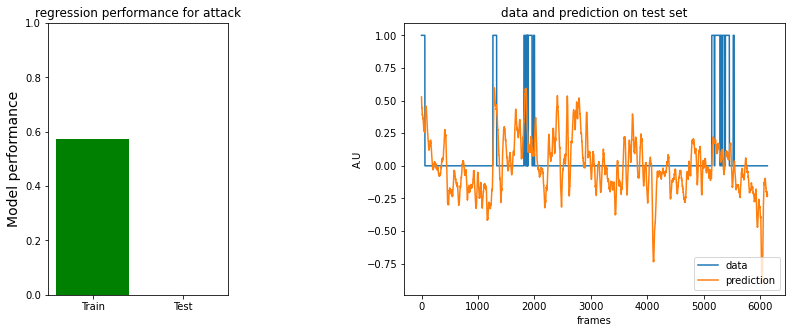

In [375]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.33, 
                                                    shuffle = False,
                                                    random_state=42)

reg = LinearRegression().fit(X_train, y_train)

# Training R2:
train_perf = reg.score(X_train, y_train)

# Test R2:
y_pred = reg.predict(X_test)
test_perf = reg.score(X_test, y_test)

# Plot performance as bar plots
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
x_pos = ['Train', 'Test']
ax1.bar(x_pos, [train_perf,test_perf], color='green')
ax1.set_ylabel("Model performance", fontsize = 14)
ax1.set_ylim((0,1))
ax1.axes.set_aspect(3)
ax1.set_title('regression performance for attack')

ax2 = plt.subplot(122)
ax2.plot(y_test, label = "data")
ax2.plot(y_pred, label = "prediction")
ax2.set_ylabel('A.U')
ax2.set_xlabel('frames')
ax2.set_title('data and prediction on test set')
ax2.legend(loc=4)


This approach reveals perhaps the most common problem faced in ML, namely overfitting. Here, the train performance of the linear model suggests that model has learnt to distinguish attack frames, however when applied on a held out test dataset, the model performance collapses

To overcome this, we apply regularization, a method where a penalty is introduced to curb overfitting. Different types of regularization exists, here we will apply LASSO (least absolute shrinkage and selection operator), a method that allows us to .....

The degree of lasso will be selected using cross validation

Text(0.5, 1.0, 'model selection for lasso')

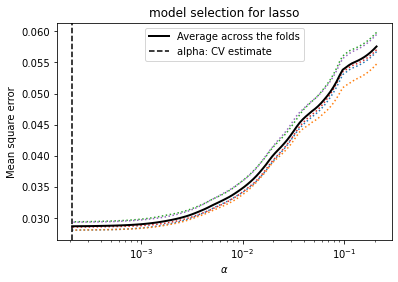

In [420]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.3, 
                                                    shuffle = True,
                                                    random_state=42)

# lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)

plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("model selection for lasso")

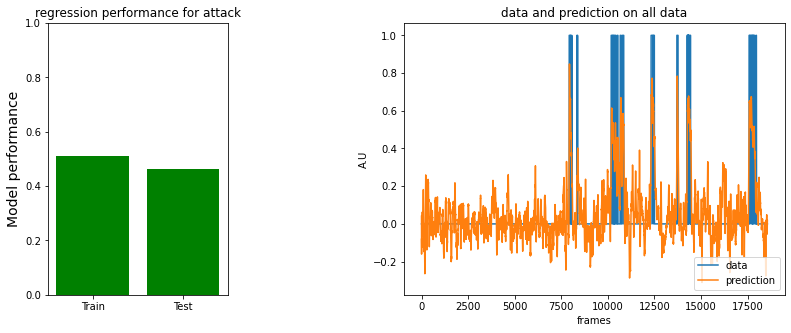

In [409]:


# Training R2:
train_perf = lasso.score(X_train, y_train)

# Test R2:
y_pred = lasso.predict(neural_data.T)
test_perf = lasso.score(X_test, y_test)

# Plot performance as bar plots
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
x_pos = ['Train', 'Test']
ax1.bar(x_pos, [train_perf,test_perf], color='green')
ax1.set_ylabel("Model performance", fontsize = 14)
ax1.set_ylim((0,1))
ax1.axes.set_aspect(3)
ax1.set_title('regression performance for attack')

ax2 = plt.subplot(122)
ax2.plot(attack_vector[0,], label = "data")
ax2.plot(y_pred, label = "prediction")
ax2.set_ylabel('A.U')
ax2.set_xlabel('frames')
ax2.set_title('data and prediction on all data')
ax2.legend(loc=4)

Thus, we can now plot what that attack signal in VMHvl looks like:

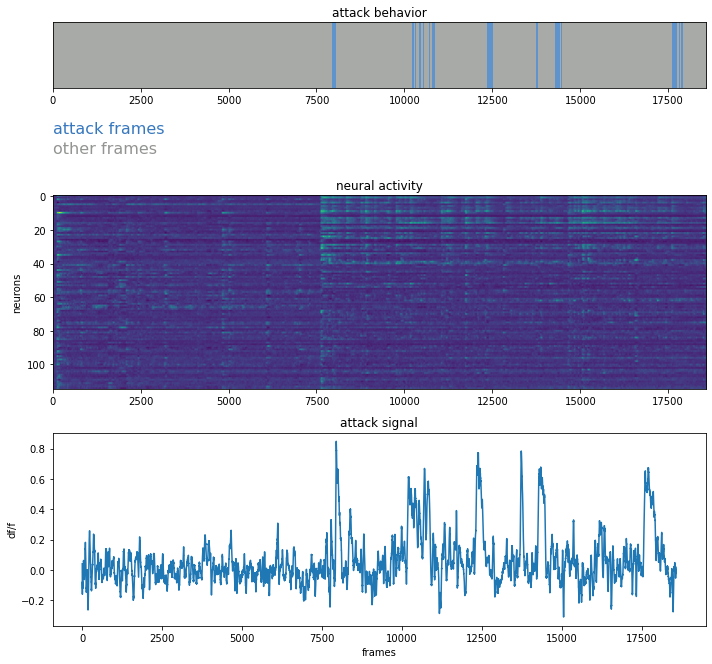

In [414]:
# plot neural activity, showing frames of attack

plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
ax1.imshow(attack_vector, aspect='auto', cmap=cmap_beh, alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior')
ax1.text(0,1.2,'attack frames',color = colors_beh[4],fontsize=16)
ax1.text(0,1.5,'other frames',color = colors_beh[0],fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(neural_data, aspect='auto')
ax2.set_title('neural activity')
ax2.set_ylabel('neurons')

ax3 = plt.subplot(313)
ax3.plot(y_pred)
ax3.set_title('attack signal')
ax3.set_ylabel('df/f')
ax3.set_xlabel('frames')

plt.tight_layout() 
